# Image Impeccable: Journey to Clarity - Starter Notebook

Welcome to the Image Impeccable Challenge. Your mission, if you choose to accept it, is to build a deep learning model that ingests 3D seismic volumes with noise and returns a 3D volume free of noise. Please see the [challenge page](https://thinkonward.com/app/c/challenges) for more details about the rules and requirements.

### Supplied Materials:

* Starter Notebook
* Training data: 250 noisy and denoised synthetic 3D seismic volume pairs
* Test data: 15 noisy 3D seismic volumes
* `utils.py` script containing helpful functions (optional)
* `requirements.txt` for all required packages

### Imports

In [21]:
# ONLY RUN THIS CELL ONCE
# REMEMBER TO ADD YOUR PACKAGES TO requirements.txt
#!pip install -r requirements.txt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
import pprint as pp
from transformers import (
    AutoImageProcessor,
    ViTMAEForPreTraining,
    ViTForMaskedImageModeling,
)
from PIL import Image
from datasets import Dataset
from torch.utils.data import DataLoader

from utils import *

# create the directories where the data is stored
if not os.path.exists("training_data"):
    os.makedirs("training_data")
if not os.path.exists("test_data"):
    os.makedirs("test_data")
if not os.path.exists("submission_files"):
    os.makedirs("submission_files")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data

Download the training and test data using `wget` directly into their respective folders.

In [ ]:
# # UNCOMMENT TO DOWNLOAD DATA

# # TRAINING DATA ---------------------------------------------------------------
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part1.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part2.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part3.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part4.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part5.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part6.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part7.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part8.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part9.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part10.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part11.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part12.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part13.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part14.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part15.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part16.zip -P ./training_data/
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-train-data-part17.zip -P ./training_data/

# # TEST DATA -------------------------------------------------------------------
# ! wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/image-impeccable/image-impeccable-test-data.zip -P ./test_data/

You have been provided with 250 paired synthetic seismic datasets. There are 500 total volumes, 250 volumes are the noisy seismic, and 250 volumes are the target denoised seismic. The synthetic data is delivered as Numpy arrays with a shape of `(1259,300,300)`.  You are free to use any inline or crosslines from the volumes that you choose for training. The output of your model must be the same shaped volumes as those provided, `(1259,300,300)`. The test dataset will contain 15 noisy seismic volumes of the same shape as the training dataset. 

Enough reading, go ahead and load up some seismic data with the cells below and take a look at what we are talking about!

In [15]:
for path, dirs, files in os.walk("./training_data"):
    if files:
        noise_fp = [os.path.join(path, file) for file in files if "noise" in file]
        seismic_fp = [os.path.join(path, file) for file in files if "seismic" in file]

In [19]:
seismic = np.load(seismic_fp[0], allow_pickle=True, mmap_mode="r+")
print(f"Seismic data shape: {seismic.shape}")
noise = np.load(noise_fp[0], allow_pickle=True, mmap_mode="r+")
print(f"Noisy data shape: {noise.shape}")

Seismic data shape: (1259, 300, 300)
Noisy data shape: (1259, 300, 300)


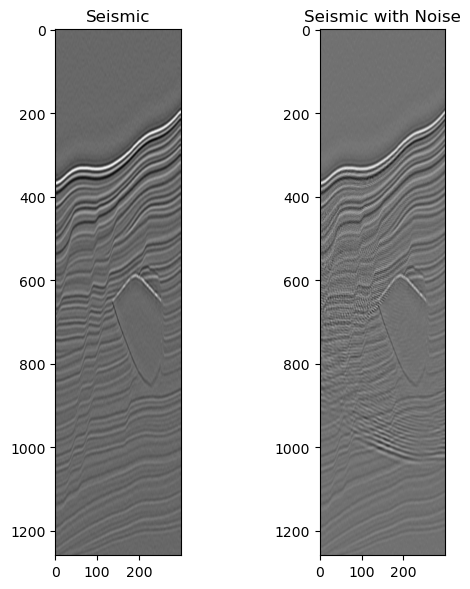

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(seismic[:, 200, :], cmap="gray")
ax[0].set_title("Seismic")
ax[1].imshow(noise[:, 200, :], cmap="gray")
ax[1].set_title("Seismic with Noise")
plt.tight_layout()
plt.show()

### Data Scaling Considerations

The data scales for this challenge may vary from volume to volume. This is an issue that is commonly encountered as a geophyiscist. We suggest using the `rescale_volume()` function below (provided in the `utils.py` script). This function will rescale the seismic data to a range between 0-255. There are also optional arguments to clip the low and high ends of the data at a given percentile. The data below has been clipped at the 2nd and 98th percentiles.

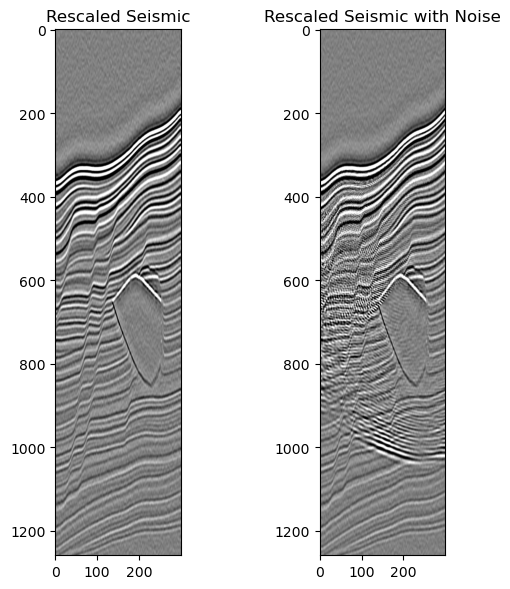

In [13]:
rescaled_seismic = rescale_volume(seismic, low=2, high=98)
rescaled_noise = rescale_volume(noise, low=2, high=98)

fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(rescaled_seismic[:, 200, :], cmap="gray")
ax[0].set_title("Rescaled Seismic")
ax[1].imshow(rescaled_noise[:, 200, :], cmap="gray")
ax[1].set_title("Rescaled Seismic with Noise")
plt.tight_layout()
plt.show()

### Example Implementation with Hugging Face 🤗

If you have not heard of [Hugging Face](https://huggingface.co/), we suggest you go check it our right now and create a free account. At ThinkOnward we are crazy about Hugging Face! We have a [ThinkOnward organization](https://huggingface.co/thinkonward) and we encourage you to follow us. In the coming months and years we will use Hugging Face to improve challenges by sharing challenge data and model results, and promote the open source geo data science community!

With that being said, we want to spend some time here demonstrating how to use the Hugging Face [transformers](https://huggingface.co/thinkonward) and [datasets](https://huggingface.co/docs/datasets/index) Python packages. These packages are the bread and butter of Hugging Face that you should become familiar with. These packages they are revolutionizing the training and deployment of deep learning models. Below we demonstrate how to create a custom Hugging Face dataset as well as pre-training and fine-tune a Vision Transformer using the `transformers` library.

##### Creating a custom dataset with Hugging Face Datasets

First, create a Hugging Face Dataset using a Pytorch dataset loader the ThinkOnward team wrote to serve 2D slices from a 3D volume. This is by no means the only way to work with the training data. In fact we are assuming that you, the brillant ThinkOnward community, will devise a more efficient methodology for loading and working with 3D volumes. We hope this example serves as an example for how to get started on the problem. We suggest you start with a small amount of data, as the dataloader can be quite computationally expensive.

In [4]:
from datasets import Dataset

In [ ]:
# create menu of slices from the 3D volumes
pretrain_dataset = CustomDataset(
    root_dir="./training_data",
    num_slices=300,  # number of slices in one direction of the cube; 300 for
    cheesecake_factory_mode=False,  # much like the menu at Cheesecake Factory, you slice menu will include everything :-)
    limit=50,  # if cheese_cake_factory_mode=False, the limit must be an int value to limit the menu
    data_prefix="seismicCubes",  # what does the data name start with
    label_prefix="",  # what does the label name start with; leave label_prefix blank when pretraining a model.
    pretraining=True,
)


# this function will be used to iterate through all 2D slices created in the CustomDataset
def gen():
    for idx in range(len(pretrain_dataset)):
        yield pretrain_dataset[idx]


# using from_generator() we import the torch dataset to a HF dataset
hf_dataset = Dataset.from_generator(gen)

dataloader = DataLoader(hf_dataset, batch_size=16, num_workers=4)

Generating train split: 0 examples [00:00, ? examples/s]

##### Pre-training a ViT backbone using Hugging Face Transformers

One of the great aspects of Hugging Face is the ease of use for pre-training and fine-tuning Vision Transformers using the `transformers` package. In this example you'll use the [AutoImageProcessor](https://huggingface.co/docs/transformers/v4.41.3/en/model_doc/vit#transformers.ViTImageProcessor) to transform input images into the required shape, size, and other parameters. Next you will load the model for pretraining using [ViTMAEForPreTraining](https://huggingface.co/docs/transformers/v4.41.3/en/model_doc/vit_mae#transformers.ViTMAEForPreTraining). This automatically sets the model up to pretrain the encoder. Finally, set up a loop with the dataloader and run your training!

In [ ]:
# the image processor will apply the same transformations that the model uses
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
# using ViTMAEForPreTraining automatically configures model parameters for pretraining
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

# here we will set up a loop through the training data for training

total_loss = []

for batch in dataloader:
    inputs = image_processor(images=batch, return_tensors="pt")
    outputs = model(**inputs)
    loss = outputs.loss
    total_loss.append(loss)
    print(f"Loss: {loss}")

##### Fine-tuning a ViT using Hugging Face Transformers

The goal of this challenge is to remove the noise from given volumes. You have been provided with a denoised version of the volume (the target) and a noisy volume (the training data). For fine-tuning the Vision Transformer, you'll work with the [ViTForMaskedImageModeling](https://huggingface.co/docs/transformers/v4.41.3/en/model_doc/vit#transformers.ViTForMaskedImageModeling) as defined by [this paper](https://arxiv.org/abs/2111.09886) highlighing SimMIM.

In [ ]:
# the image processor will apply the same transformations that the model uses
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
# loading model parameters for ImageModeling
model = ViTForMaskedImageModeling.from_pretrained(
    "your/checkpoint/here", local_files_only=True
)

In [ ]:
for batch in dataloader:
    num_patches = (model.config.image_size // model.config.patch_size) ** 2
    pixel_values = image_processor(images=image, return_tensors="pt").pixel_values
    # create random boolean mask of shape (batch_size, num_patches)
    bool_masked_pos = torch.randint(low=0, high=2, size=(1, num_patches)).bool()
    outputs = model(pixel_values, bool_masked_pos=bool_masked_pos)
    loss, reconstructed_pixel_values = outputs.loss, outputs.reconstruction
    list(reconstructed_pixel_values.shape)
    print(f"Loss: {loss}")

### Solution

In [14]:
%%time
# YOUR SOLUTION HERE

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


### Submission File Generation

The ThinkOnward team has provided challengers with submission file generation code, which can be found in the `utils.py` script. There are two functions provided that will be useful; `create_single_submission()` and `create_submission()`.

`create_single_submission()` allows you to create a single submission file for any number of volumes. This should be used for testing purposes. Once you have predictions from your model, you can create a single submission file to test in the scoring function provided in the `Evaluation` section. 

`create_submission()` should be used as the final output submission file for challengers to provide to the scoring page.

Below is an example of how you might load some training data and create a submission file. While we encourage testing of the submission file generation and scoring code using training data, the final submission will be generated using the 15 test volumes.

For the sake of testing, create 3 randomly generated predictions using Numpy and save them to the predictions folder.

In [ ]:
example1 = np.random.rand(1259, 300, 300)
example2 = np.random.rand(1259, 300, 300)
example3 = np.random.rand(1259, 300, 300)
np.save("./predictions/example1.npy", example1)
np.save("./predictions/example2.npy", example2)
np.save("./predictions/example3.npy", example3)

Next, you'll use these test predictions to create the `seismic_filenames` and `predictions` lists that contain the required info to feed into `create_submission()` below.

In [25]:
predictions_path = (
    "./predictions/"  # Path to your predictions folder or training data folder
)
seismic_filenames = sorted(
    [
        file.split("/")[0]
        for path, dirs, files in os.walk(predictions_path)
        for file in files
        if file.endswith(".npy")
    ]
)  # ensure that the filenames are sorted
print(seismic_filenames)

predictions = []
for seismic_filename in seismic_filenames:
    seismic = np.load(f"{predictions_path}{seismic_filename}")
    seismic = rescale_volume(seismic, low=0, high=100)#rescale, no clipping
    predictions.append(seismic)
    print(seismic_filename, "loaded")

['example1.npy', 'example2.npy', 'example3.npy']
example1.npy loaded
example2.npy loaded
example3.npy loaded


Let's say you want to create a single submission file just to test your model's quality. Here is code that creates one single submission file to feed into the scoring algorithm provided below. You can create your own ground truth file by using the denoised volumes provided to create a ground truth submission file for use in the scoring algorithm below. 

In [ ]:
for seismic_filename, target in zip(seismic_filenames, predictions):
    create_single_submission(
        seismic_filename,
        prediction=target,
        submission_path="./submission_files/example_submission1.npz",
    )

Creating the final submission method

In [ ]:
create_submission(
    seismic_filenames,
    prediction=predictions,
    submission_path="./submission_files/example_submission2.npz",
)

You'll notice that the folders for the naming convention for the test data is slightly different. To create a submission file free of errors, you'll need to use the names of the subfolders where each test volume sits. The seismic_filenames should equal `['2024-06-10_0d6402b1', '2024-06-10_1a4e5680', '2024-06-10_1b9a0096', '2024-06-10_2bd82c05', '2024-06-10_3b118e17', '2024-06-10_43537d46', '2024-06-10_662066f4', '2024-06-10_971ac6dd', '2024-06-10_9871c8c6', '2024-06-10_b7c329be', '2024-06-10_bfd43f22', '2024-06-10_c952ed24', '2024-06-10_cec3da7f', '2024-06-10_eb45f27e', '2024-06-11_f46c20fe']`.

Remember to review the `image-impeccable-baseline-submission.npz` and  `image-impeccable-test-submission.npz` format and naming convention prior to submitting your predictions.

### Evaluation

The leaderboard evaluation will use the `scikit-image` implementation of the [Structural Similarity Index](https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html). The Structural Similarity Index is a metric used to measure the similarity between two images. When the SSI equals 1, the images are identical. When the SSI equals 0, the images are completely dissimilar. Please refer to the `scikit-image` docs for more information about the metric, as well as examples for implementaion. Because we are using the same volumes for predicition and ground-truth below, the SSI = 1.0.

In [ ]:
score = scoring(
    prediction_path="./submission_files/example_submission1.npz",
    ground_truth_path="./submission_files/example_submission2.npz",
)
print(f"Structural Similarity Score: {score}")

Structural Similarity Score: 1.0
